# TME 2 - Explication par génération d'exemples contre-factuels divers

Travail réalisé par :

* BENSIDHOUM Azzedine
* BENHADDAD Sabrina

## 1. Installation

installation du module dice-ml

In [ ]:
!pip install dice_ml

Importation des bibliothèques requises pour le TME

In [ ]:
import dice_ml

import numpy as np
import pandas as pd

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from scipy.spatial import distance


import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

<ipython-input-172-9bfb6ce54c5f>:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 2. Données

* Génération de données "**halfmoons**" en dimension 2
* Affichage des données
* Conversion des données sous forme d'un DataFrame pour faciliter leur manipulation avec dice_ml
* Conversion du dataFrame en une structure interne spécifique au module dice_ml par la commande donnée en TME *dice_ml.Data()*

In [ ]:
#Génération des données halfmoons avec un bruit de 0.15 en dimension 2
x, y = make_moons(n_samples=1000, noise = 0.15)

In [ ]:
y = y.reshape(-1, 1)
print(f"Shape of x: {x.shape}")
print(f"Shape of y: {y.shape}")

Shape of x: (1000, 2)
Shape of y: (1000, 1)


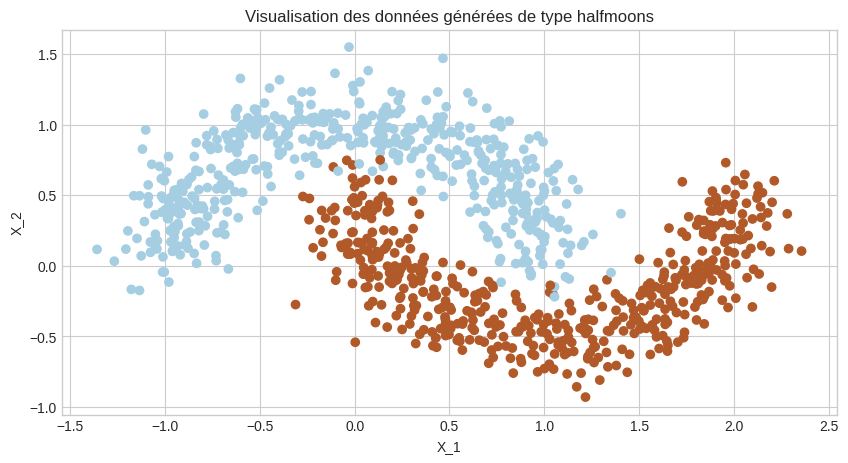

In [ ]:
#Affichage des données
plt.figure(figsize=(10, 5))
plt.title("Visualisation des données générées de type halfmoons")
plt.xlabel("X_1")
plt.ylabel("X_2")
plt.scatter(x[:, 0], x[:,1], c=y, cmap=plt.cm.Paired)
plt.axis();

In [ ]:
#Conversion des données en DataFrame
df = pd.DataFrame(data = x, columns = ['x1','x2'])
df['label'] = y
df

x1        x2  label
0    2.048232  0.302519      1
1    0.696717  1.116302      0
2   -1.010191  0.476729      0
3   -0.962039  0.380909      0
4   -0.167669  1.047952      0
..        ...       ...    ...
995 -0.899649  0.449693      0
996  0.729485 -0.154133      1
997 -0.796078  1.074464      0
998 -0.639526  0.704568      0
999 -1.010837  0.062868      0

[1000 rows x 3 columns]

In [ ]:
#Utilisation de la fonction dice_ml.Data() du module dice_ml
data = dice_ml.Data(dataframe = df, continuous_features = ['x1','x2'], outcome_name = 'label')
data

## 3. Classifieurs

Pour cette première phrase, nous utiliserons des classifieurs de sklearn

In [ ]:
target = df.label
# conserve la colonne label necessaire à la conversion avec dice-ml
dfX_train, dfX_test, Y_train, Y_test = train_test_split(df,
                                                    target,
                                                    test_size=0.3,
                                                   random_state = 0)
# Supprime la colonne label pour pouvoir entraîner le modèle sur le bon format de données
X_train = dfX_train.drop('label', axis = 1)
X_test = dfX_test.drop('label', axis = 1)

In [ ]:
# conversion avec dice-ml
data = dice_ml.Data(dataframe = dfX_train, continuous_features = ['x1','x2'] , outcome_name = 'label')
data

In [ ]:
# Entrainement du classifieur sklearn
clf = SVC(kernel = 'rbf', C = 1.0,probability=True)
trained_classifier = clf.fit(X_train, Y_train)

In [ ]:
#Classifieur chargé au format DiCE par la commande suivante
model = dice_ml.Model(model = trained_classifier, backend = 'sklearn')
model

## 4. Génération d'ensemles contre-factuels

In [ ]:
# Initialisation de l'expliqueur
explainer = dice_ml.Dice(data,model, method = 'random')
explainer

In [ ]:
# choix d'une donnée
x_ = X_test[0:1]
y_ = Y_test[0:1]

print(f"x_ :{x_}")
print(f"y_ :{y_}")

x_ :           x1        x2
993  0.514269  0.599158
y_ :993    0
Name: label, dtype: int64


In [ ]:
counterfactuals = explainer.generate_counterfactuals(X_test[0:1],
                                                     total_CFs = 3,
                                                     desired_class = "opposite",
                                                     proximity_weight=0.5,
                                                     diversity_weight=1.0,
                                                     features_to_vary="all",
                                                     permitted_range=None,
                                                     posthoc_sparsity_param=0.1)

counterfactuals

100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


## 5. Récupération des exemples contre-factuels générés

In [ ]:
# Visualisation des contrefactuels générés sous for de DataFrame
counterfactuals.visualize_as_dataframe()

Query instance (original outcome : 0)


x1        x2  label
0  0.514269  0.599158      0


Diverse Counterfactual set (new outcome: 1.0)


x1        x2  label
0  0.514269 -0.884265      1
1  0.514269 -0.512049      1
2  0.008119  0.599158      1

In [ ]:
#Autre méthode pour accéder aux contrefactuels générés
e_opts = counterfactuals.cf_examples_list[0].final_cfs_df
e_opts

x1        x2  label
0  0.514269 -0.884265      1
1  0.514269 -0.512049      1
2  0.008119  0.599158      1

## 6. Visualisation et expérimentations

### 6.1 Visualisation
Commençons comme l'algorithme Growing Spheres, dans le cas des half_moons, par la visualisation :    
* Des données d'apprentissage
* De la frontière de décision
* De la requête  
* De l'ensemble des contre-factuels générés

In [ ]:
type(X_train), type(x_), type(e_opts)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [ ]:
def visualisation(classifieur,x_, e_opts,title):
    """
    Fonction permettant de visualiser les éléments mentionnés dans l'énoncé

        Paramètres :
        - Classifieur : le classifieur considéré
        - x : les données du modèle (ndarray numpy)
        - x_ : la donnée à expliquer (ndarray numpy)
        - e_opts : liste d'exemples contre-factuels (ndarray numpy)

        Returns:
        - None
    """

    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

    Z = classifieur.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.3,cmap="seismic")

    plt.title(title)
    #plt.xlabel("x1")
    #plt.ylabel("x2")

    plt.scatter(X_train.to_numpy()[:,0], X_train.to_numpy()[:, 1], marker='o', edgecolors='k', alpha=0.5, color=[['navy', 'darkred'][i] for i in Y_train])
    plt.scatter(x_[:,0], x_[:,1], marker='o', color='yellow', edgecolors='k', s= 70,label="Observation")
    plt.scatter(e_opts[:, 0], e_opts[:, 1],marker='D', color='orange', edgecolors='k',s = 50, label="Contre-factuels")
    plt.axis();

    plt.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


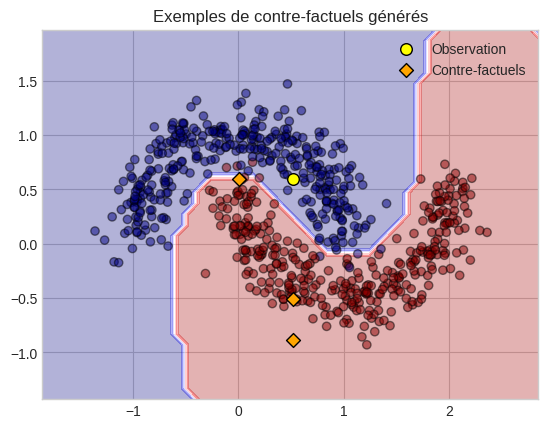

In [ ]:
# convertir les données en ndarray numpy si necessaire ou supprimer .to_numpy() si génère une erreur
visualisation(clf, x_.to_numpy(), e_opts.to_numpy(), "Exemples de contre-factuels générés")

### 6.2 Expérimentations

Examiner les résultats obtenus en faisant varier l'exemple requête, les paramètres ou le classifieur

#### A. Variation de l'exemple de requête

In [ ]:
def var_donnee(clf, data, method):
  model = dice_ml.Model(model = clf, backend = 'sklearn')
  #Nous allons générer 5 points de l'ensemble de test qui représenteront l'observation
  idx = np.random.randint(X_test.shape[0], size = 5)

  if method is None : #DiCE identifie les exemples contrefactuels en optimisant de la fonction de coût préentée dans les transparents.
    explainer = dice_ml.Dice(data,model)
  else :
    explainer = dice_ml.Dice(data,model, method)
  for i in idx :
    #On fixe par défaut le nombre de contre-factuels générés à 5
    counterfactuals = explainer.generate_counterfactuals(X_test[i:i+1],
                                                     total_CFs = 5,
                                                     desired_class = "opposite",
                                                     proximity_weight=0.5,
                                                     diversity_weight=1.0,
                                                     features_to_vary="all",
                                                     permitted_range=None,
                                                     posthoc_sparsity_param=0.1)
    e_opts = counterfactuals.cf_examples_list[0].final_cfs_df
    title = "Instance n°" + str(i)
    visualisation(clf, X_test[i:i+1].to_numpy(),e_opts.to_numpy(),title )


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


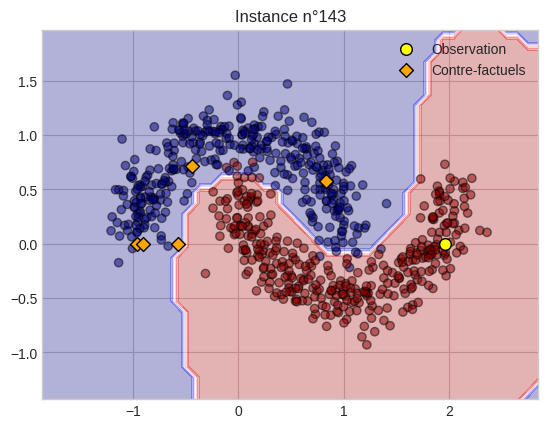

100%|██████████| 1/1 [00:00<00:00,  8.89it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


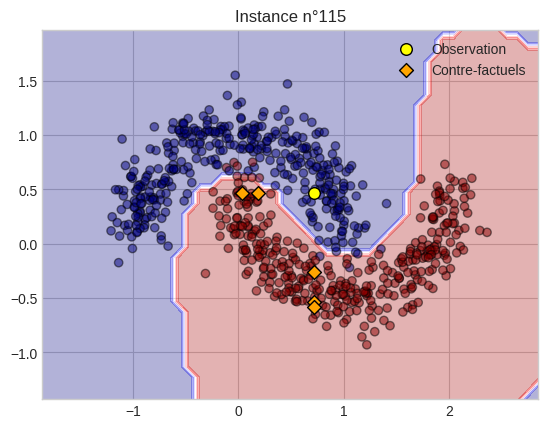

100%|██████████| 1/1 [00:00<00:00,  9.50it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


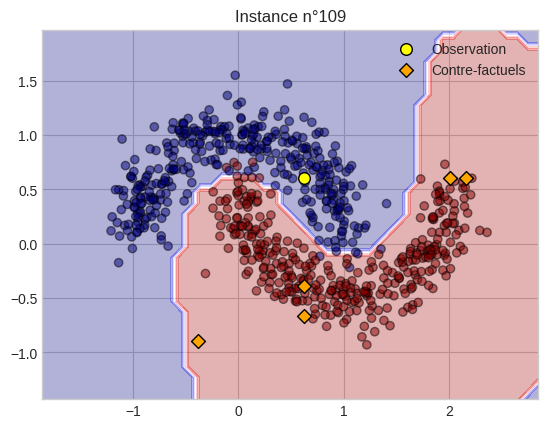

100%|██████████| 1/1 [00:00<00:00,  8.06it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


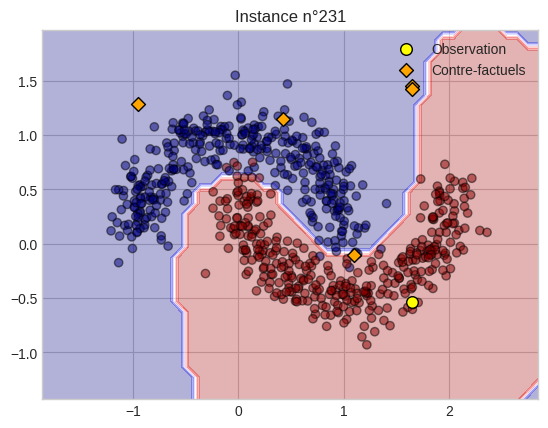

100%|██████████| 1/1 [00:00<00:00,  9.36it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


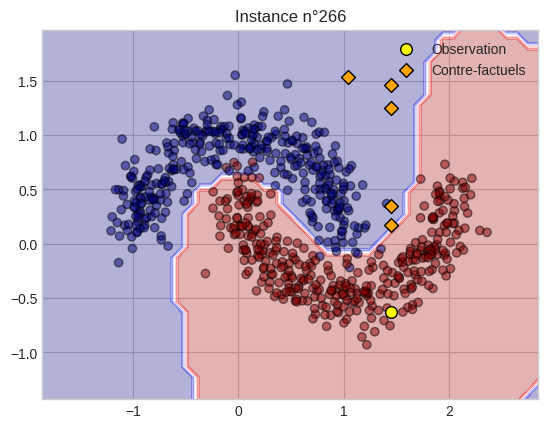

In [ ]:
df_x = df.drop('label', axis = 1)
y = df['label']
X_train, X_test, Y_train, Y_test = train_test_split(df_x, y, test_size = 0.3, random_state = 42)

clf = SVC(kernel ='rbf', C= 1.0, probability=True).fit(X_train, Y_train)

data = dice_ml.Data(dataframe=df, continuous_features=['x1', 'x2'], outcome_name = 'label')


var_donnee(clf, data, method = 'random')#Pour cette expérimentation, nous allons considérer la méthode random sampling

On remarque que pour une variété d'observations générées, les contre-factuels associés (classifieur SVM et identification des exemples à l'aide de la méthode 'random sampling', c'est à dire une sélection ou échantillonnage aléatoire des exemples contre-factuels) restent toujours cohérents.
Ils appartiennent autrement dit à la classe opposée à chaque fois.

#### B. Variation des paramètres

Dans cette section,  nous allons nous intéresser à la variation des paramètres de génération des exemples contre-factuels, autrement dit, du paramètres **method** de la fonction *dice_ml.Dice()*

À noter qu'il existe 3 méthodes d'explications pour des modèles sklearn :     
* Random Sampling == *random*
* Genetic algorithm search == *genetic*
* kdtree based generation == *kdtree*

Sinon, DiCE identifie les exemples contrefactuels en optimisant de la fonction de coût présentée dans les transparents, qu'on représentera ici par *None*


In [ ]:
def var_method(clf,data,obs):
  methodes = ['random','genetic','kdtree',None]
  model = dice_ml.Model(model = clf, backend='sklearn')

  for methode in methodes :
    if methode is None :
      explainer = dice_ml.Dice(data,model)
    else :
      explainer = dice_ml.Dice(data, model, methode)

    #On fixe par défaut le nombre de contre-factuels générés à 5
    counterfactuals = explainer.generate_counterfactuals(obs,
                                                     total_CFs = 5,
                                                     desired_class = "opposite",
                                                     proximity_weight=0.5,
                                                     diversity_weight=1.0,
                                                     features_to_vary="all",
                                                     permitted_range=None,
                                                     posthoc_sparsity_param=0.1)
    e_opts = counterfactuals.cf_examples_list[0].final_cfs_df
    title = "Génération de contre-facutels avec la méthode : " + str(methode)
    visualisation(clf,obs.to_numpy(),e_opts.to_numpy(),title )


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


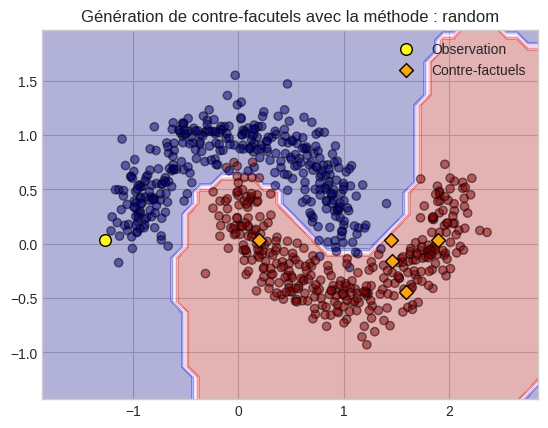

100%|██████████| 1/1 [00:00<00:00, 16.23it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


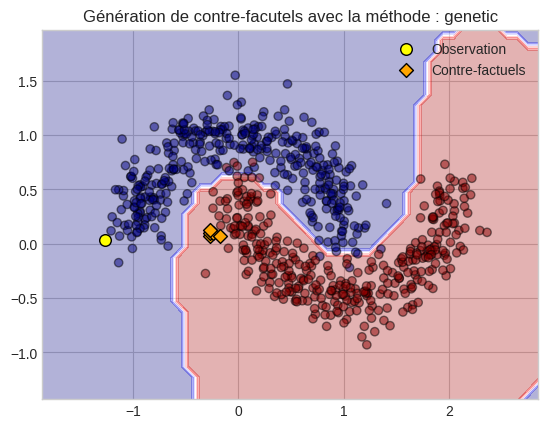

100%|██████████| 1/1 [00:28<00:00, 28.04s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


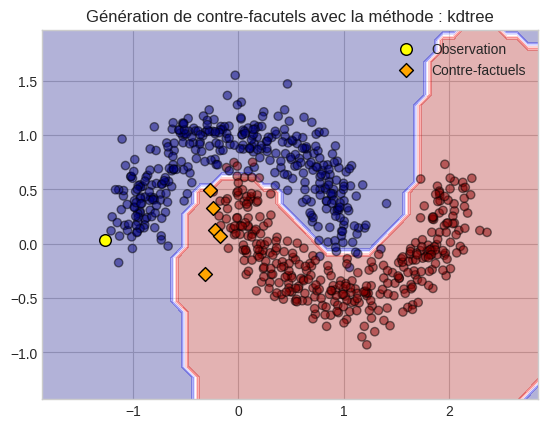

100%|██████████| 1/1 [00:00<00:00,  9.14it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


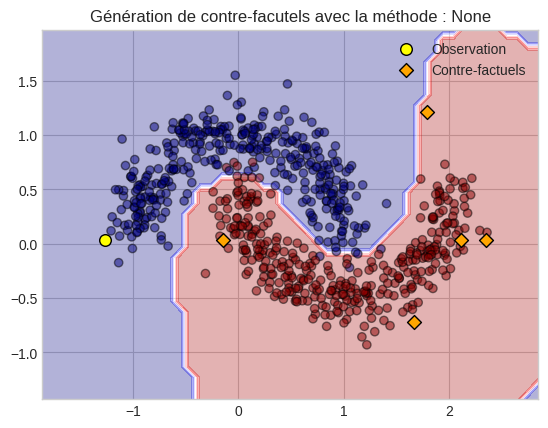

In [ ]:
df_x = df.drop('label', axis = 1)
y = df['label']
X_train, X_test, Y_train, Y_test = train_test_split(df_x, y, test_size = 0.3, random_state = 42)

clf = SVC(kernel ='rbf', C= 1.0, probability=True).fit(X_train, Y_train)

data = dice_ml.Data(dataframe=df, continuous_features=['x1', 'x2'], outcome_name = 'label')

var_method(clf, data, X_test[0:1])

Comme nous pouvons le voir, la génération de contre-factuels varie d'une méthode à une autre.

1. Random :      

L'échantillonnage aléatoire consiste à générer des exemples contre-factuels en effectuant des modifications aléatoires des caractéristiques de notre observation.
Nous obtenons donc, des contre-factuels variables d'une exécution à une autre (certains peuvent être proches de l'observation tandis que d'autres peuvent être très loin)

2. Genectic :        

Les algorithmes génétiques permettent de trouver des exemples contre-factuels en explorant différentes combinaisons de caractéristiques.
C'est ce qui explique ainsi, la génération de contre-factuels très proches et valides.

3. Kdtree :     

L'utilisation d'un arbre kd permet de générer des exemples contre-factuels tout en favorisant la solution des solutions générées.
C'est ce qui explique encore une fois, la proximité des exemples par rapport à l'observation.


À noter que le choix de la méthode varie en fonction des critères d'évaluation considérés (validité, proximité, rapidité etc...)

#### C. Variation du classifieur

Dans cette section, nous expérimenterons la variation du classifieur (toujours au sein de la bibliothèque sklearn) avec la méthode *'random'*


In [ ]:
def var_class(data, method,obs):
  classifieur = [SVC(kernel ='rbf',C=1.0, probability=True),KNeighborsClassifier(n_neighbors=3),RandomForestClassifier(max_depth = 4, random_state = 0),tree.DecisionTreeClassifier(max_depth=4),LogisticRegression()]
  for i, c in enumerate(classifieur ):
    print(f"---------- Entrainement modèle {i+1} ----------")
    clf = c.fit(X_train, Y_train)
    model = dice_ml.Model(model = clf, backend='sklearn')
    y_pred = clf.predict(X_test)
    print(f"Précision du modèle {str(clf)}: {accuracy_score(Y_test, y_pred) * 100}")

    if method is None :
      explainer = dice_ml.Dice(data, model)
    else :
      explainer = dice_ml.Dice(data, model, method = method)

    counterfactuals = explainer.generate_counterfactuals(obs,
                                                     total_CFs = 5,
                                                     desired_class = "opposite",
                                                     proximity_weight=0.5,
                                                     diversity_weight=1.0,
                                                     features_to_vary="all",
                                                     permitted_range=None,
                                                     posthoc_sparsity_param=0.1)

    e_opts = counterfactuals.cf_examples_list[0].final_cfs_df

    title = str(clf)
    visualisation(clf,obs.to_numpy(),e_opts.to_numpy(),title)

---------- Entrainement modèle 1 ----------
Précision du modèle SVC(probability=True): 99.66666666666667


100%|██████████| 1/1 [00:00<00:00, 11.29it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


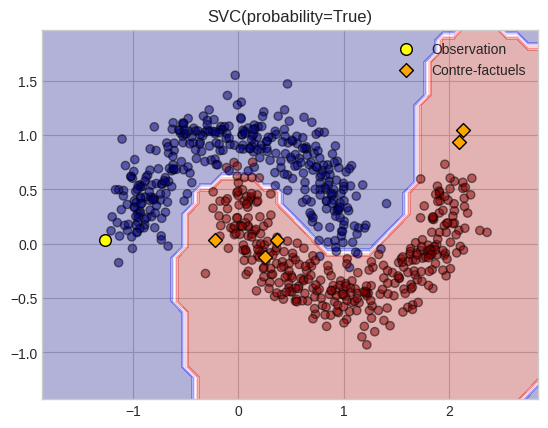

---------- Entrainement modèle 2 ----------
Précision du modèle KNeighborsClassifier(n_neighbors=3): 99.33333333333333


100%|██████████| 1/1 [00:19<00:00, 19.69s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


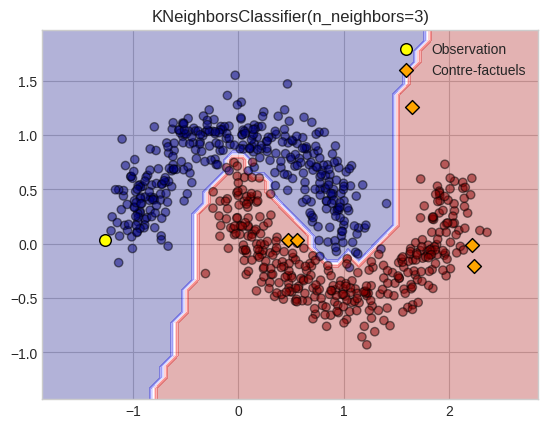

---------- Entrainement modèle 3 ----------
Précision du modèle RandomForestClassifier(max_depth=4, random_state=0): 96.33333333333334


100%|██████████| 1/1 [00:00<00:00,  6.50it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


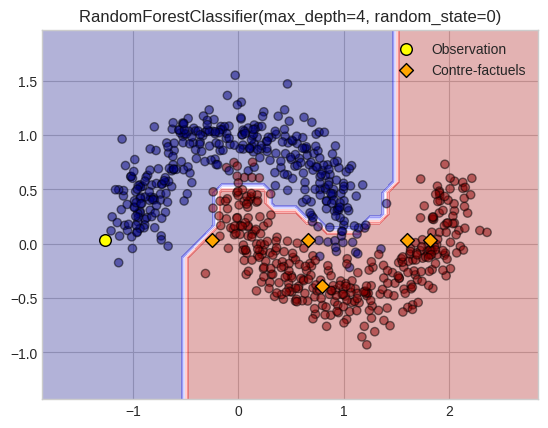

---------- Entrainement modèle 4 ----------
Précision du modèle DecisionTreeClassifier(max_depth=4): 91.33333333333333


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


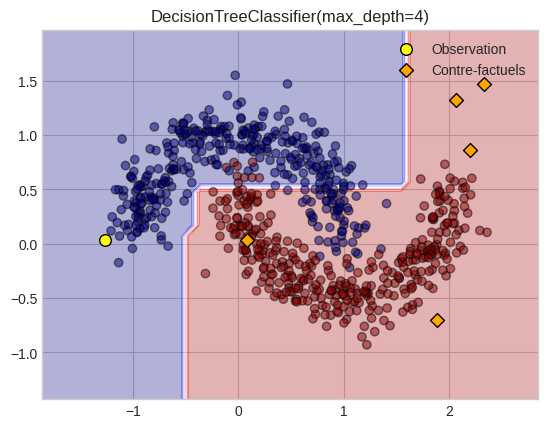

---------- Entrainement modèle 5 ----------
Précision du modèle LogisticRegression(): 89.0


100%|██████████| 1/1 [00:17<00:00, 17.44s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


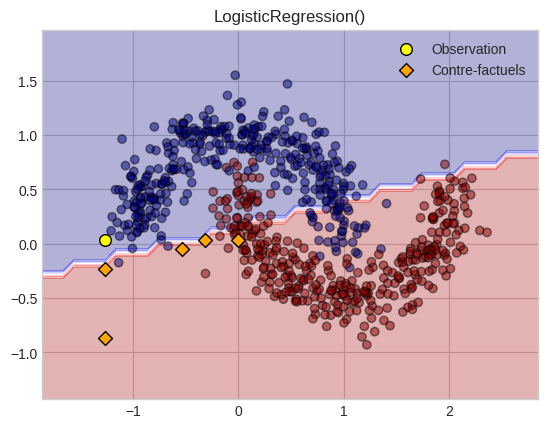

In [ ]:
df_x = df.drop('label', axis = 1)
y = df['label']
X_train, X_test, Y_train, Y_test = train_test_split(df_x, y, test_size = 0.3, random_state = 42)

data = dice_ml.Data(dataframe=df, continuous_features=['x1', 'x2'], outcome_name = 'label')
method = 'random'

var_class(data,method,X_test[0:1])


Nous pouvons aisément constater que les contre-factuels générés diffèrent d'un classifieur à un autre.

Certains donnent des contre-factuels proches de la frontière de décision (à l'image du SVM) tandis que d'autres génére des contre-factuels relativement flexibles et aléatoires.


### 6.3 Implémentation de critères d'évaluation numériques

En ce qui concerne la validité, nous allons l'évaluer à partir :       
* De la visualisation des exemples contre-factuels générés
* De la classe à laquelle ils apparitiennent

Pour la proximité, nous utiliserons la fonction **distance.cdist** de *Scipy.spatial*

et pour la parcimonie, la fonction ci-dessous

In [ ]:
def calculate_sparsity(original_features, generated_features):
    num_modified_features = np.sum(original_features != generated_features)
    sparsity_ratio = num_modified_features / original_features.size
    return sparsity_ratio

Observons leur évolution lorsque les paramètres de la méthode **generate_counterfactuals** varie

#### 1. Variation du nombre de contre-factuels à générer

Autrement dit variation de la variable total_CFs


In [ ]:
def var_cfs(clf,obs, data, methode):

  cfs = [2,5,10,15,20]

  model = dice_ml.Model(model = clf, backend='sklearn')
  if methode is None :
      explainer = dice_ml.Dice(data,model)
  else :
      explainer = dice_ml.Dice(data, model, methode)

  for c in cfs :
    proximite = []
    counterfactuals = explainer.generate_counterfactuals(obs,
                                                     total_CFs = c,
                                                     desired_class = "opposite",
                                                     proximity_weight=0.5,
                                                     diversity_weight=1.0,
                                                     features_to_vary="all",
                                                     permitted_range=None,
                                                     posthoc_sparsity_param=0.1)
    e_opts = counterfactuals.cf_examples_list[0].final_cfs_df
    title = "Génération de " + str(c) +" contre-factuels"
    visualisation(clf,obs.to_numpy(),e_opts.to_numpy(),title )
    print(e_opts)
    proximite.append(distance.cdist(obs.to_numpy(), e_opts.drop('label', axis = 1).to_numpy(), 'euclidean'))
    print("Proximité des exemples : ",proximite)
    print("Ratio de parcimonie ",calculate_sparsity(obs.to_numpy(),e_opts.drop('label', axis = 1).to_numpy()))


Classe de l'observation [0]


100%|██████████| 1/1 [00:00<00:00, 11.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


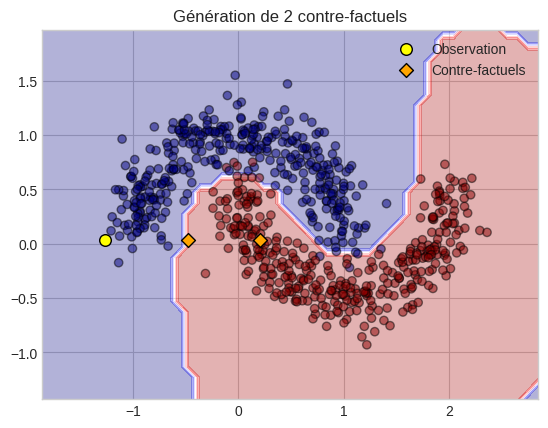

         x1        x2  label
0  0.201937  0.032595      1
1 -0.475907  0.032595      1
Proximité des exemples :  [array([[1.46927127, 0.79142756]])]
Ratio de parcimonie  1.0


100%|██████████| 1/1 [00:16<00:00, 16.66s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


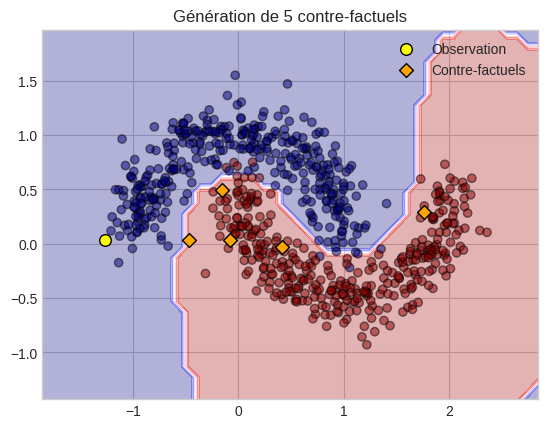

         x1        x2  label
0  1.761706  0.290146      1
1 -0.465225  0.032595      1
2 -0.077312  0.032595      1
3 -0.150634  0.490218      1
4  0.413355 -0.031707      1
Proximité des exemples :  [array([[3.03997006, 0.80210987, 1.19002295, 1.20683013, 1.681919  ]])]
Ratio de parcimonie  4.0


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


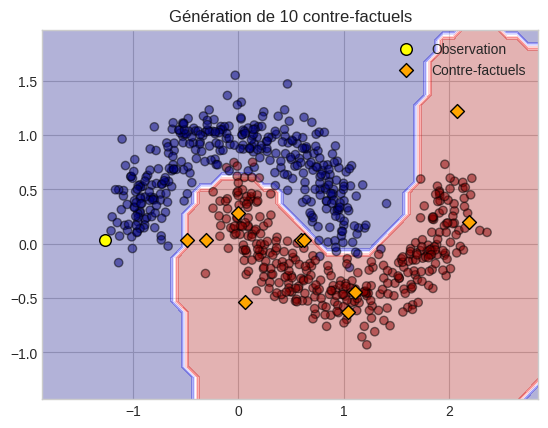

         x1        x2  label
0 -0.486197  0.032595      1
1  0.593476  0.032595      1
2  0.620302  0.032595      1
3  0.058303 -0.541263      1
4  2.188283  0.195076      1
5  1.105032 -0.448779      1
6  2.068873  1.218099      1
7  0.000522  0.284961      1
8 -0.307141  0.032595      1
9  1.043647 -0.630910      1
Proximité des exemples :  [array([[0.78113812, 1.86081052, 1.88763642, 1.4445166 , 3.45943563,
        2.42071136, 3.54057921, 1.29272962, 0.96019406, 2.40434491]])]
Ratio de parcimonie  8.0


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


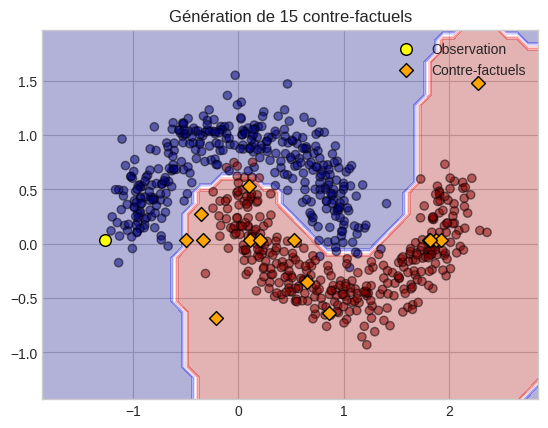

          x1        x2  label
0  -0.335225  0.032595      1
1   0.861166 -0.639761      1
2  -0.213675 -0.681856      1
3   0.654324 -0.349513      1
4   2.275502  1.476960      1
5  -0.349268  0.271147      1
6   0.526755  0.032595      1
7   0.108326  0.032595      1
8   0.202530  0.032595      1
9   1.869288  0.032595      1
10  0.102498  0.531239      1
11 -0.497873  0.032595      1
12  1.915777  0.032595      1
13  1.801937  0.032595      1
14  1.812912  0.032595      1
Proximité des exemples :  [array([[0.93211013, 2.23216933, 1.27304321, 1.95928002, 3.82594827,
        0.94855358, 1.79408973, 1.37566095, 1.46986429, 3.1366224 ,
        1.45776853, 0.7694614 , 3.18311158, 3.06927154, 3.08024631]])]
Ratio de parcimonie  10.5


100%|██████████| 1/1 [00:35<00:00, 35.47s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


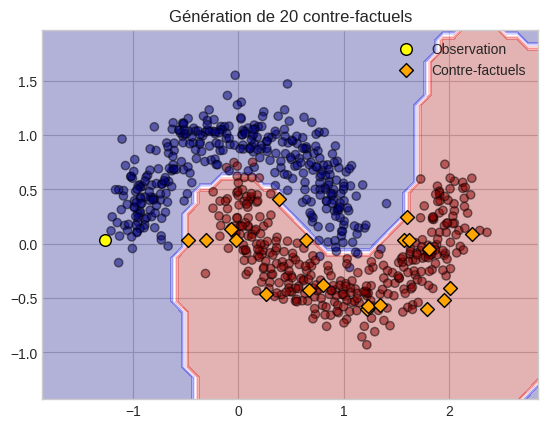

          x1        x2  label
0   0.261909 -0.465435      1
1   0.388243  0.409022      1
2   0.645659  0.032595      1
3  -0.476192  0.032595      1
4  -0.071082  0.137330      1
5   0.799100 -0.376483      1
6   0.667201 -0.424389      1
7  -0.303564  0.032595      1
8   2.212983  0.086768      1
9   1.217256 -0.598463      1
10  1.227259 -0.572398      1
11  1.805488 -0.048270      1
12  1.594587  0.246414      1
13  1.949517 -0.514673      1
14  1.782952 -0.600684      1
15  1.574271  0.032595      1
16  2.006860 -0.409626      1
17  1.337954 -0.561748      1
18 -0.026378  0.032595      1
19  1.616881  0.032595      1
Proximité des exemples :  [array([[1.60829749, 1.69783244, 1.91299386, 0.79114266, 1.20082895,
        2.106537  , 1.98777866, 0.96377084, 3.48073965, 2.56347934,
        2.56690772, 3.07388641, 2.86989761, 3.26307183, 3.11533116,
        2.84160564, 3.30392329, 2.67222206, 1.24095701, 2.88421521]])]
Ratio de parcimonie  17.0


In [ ]:
df_x = df.drop('label', axis = 1)
y = df['label']
X_train, X_test, Y_train, Y_test = train_test_split(df_x, y, test_size = 0.3, random_state = 42)

clf = SVC(kernel ='rbf', C= 1.0, probability=True).fit(X_train, Y_train)
print("Classe de l'observation",clf.predict(X_test[0:1]))

data = dice_ml.Data(dataframe=df, continuous_features=['x1', 'x2'], outcome_name = 'label')

var_cfs(clf, X_test[0:1], data, 'random')

Comme nous pouvons le constater, la variation du nombre de contre-factuels générés n'influe par sur la validité de l'algorithme.
En effets ils appartiennent tous à la classe opposée

Quand à la parcimonie, cette dernière augmente à mesure que le nombre de contre-factuels augmente. Ce qui indique que la génération de plusieurs contre-factuels entraine une modification minimal des caractéristiques de l'observation.

Les exemples sont également plus proches

#### 2. Variation de la proximité

Autrement dit variation de la variable proximity_weight

In [ ]:
def var_prox(clf,obs, data, methode):

  prox = [0.25,0.5,1.0,1.5,5.0]

  model = dice_ml.Model(model = clf, backend='sklearn')
  if methode is None :
      explainer = dice_ml.Dice(data,model)
  else :
      explainer = dice_ml.Dice(data, model, methode)

  for p in prox :
    proximite = []
    #On génére 5 contre-factuels
    counterfactuals = explainer.generate_counterfactuals(obs,
                                                     total_CFs = 5,
                                                     desired_class = "opposite",
                                                     proximity_weight=p,
                                                     diversity_weight=1.0,
                                                     features_to_vary="all",
                                                     permitted_range=None,
                                                     posthoc_sparsity_param=0.1)
    e_opts = counterfactuals.cf_examples_list[0].final_cfs_df
    title = "Proximité : "+ str(p)
    visualisation(clf,obs.to_numpy(),e_opts.to_numpy(),title )
    print(e_opts)
    proximite.append(distance.cdist(obs.to_numpy(), e_opts.drop('label', axis = 1).to_numpy(), 'euclidean'))
    print("Proximité des exemples : ",proximite)
    print("Ratio de parcimonie ",calculate_sparsity(obs.to_numpy(),e_opts.drop('label', axis = 1).to_numpy()))


Classe de l'observation [0]


100%|██████████| 1/1 [00:00<00:00, 11.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


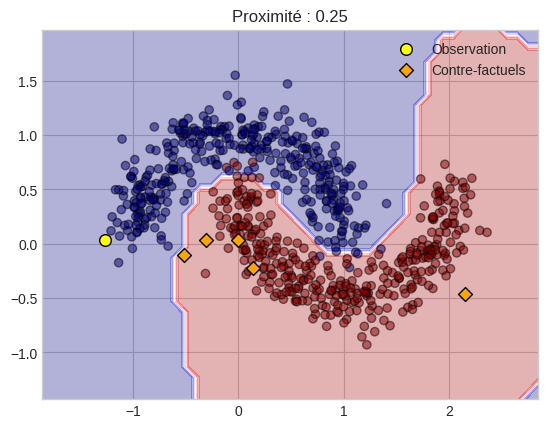

         x1        x2  label
0  0.139065 -0.222992      1
1 -0.513416 -0.103361      1
2 -0.309038  0.032595      1
3  0.000395  0.032595      1
4  2.150880 -0.460712      1
Proximité des exemples :  [array([[1.42943516, 0.76607884, 0.95829625, 1.2677297 , 3.45362745]])]
Ratio de parcimonie  4.0


100%|██████████| 1/1 [00:00<00:00, 10.79it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


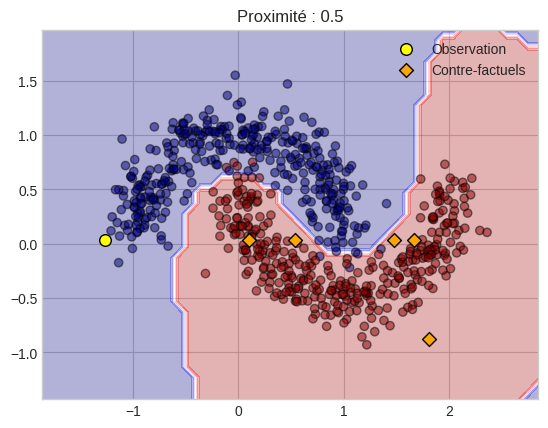

         x1        x2  label
0  1.473731  0.032595      1
1  1.807951 -0.881511      1
2  0.534041  0.032595      1
3  0.100717  0.032595      1
4  1.666450  0.032595      1
Proximité des exemples :  [array([[2.74106585, 3.20826624, 1.80137601, 1.36805208, 2.93378513]])]
Ratio de parcimonie  3.0


100%|██████████| 1/1 [00:00<00:00,  9.58it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


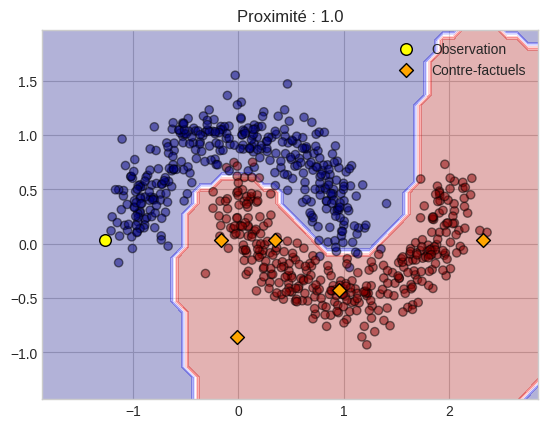

         x1        x2  label
0  0.347210  0.032595      1
1  2.316739  0.032595      1
2  0.952618 -0.427163      1
3 -0.011790 -0.856056      1
4 -0.166236  0.032595      1
Proximité des exemples :  [array([[1.614545  , 3.58407412, 2.26706171, 1.53821049, 1.10109844]])]
Ratio de parcimonie  3.5


100%|██████████| 1/1 [00:00<00:00, 10.07it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


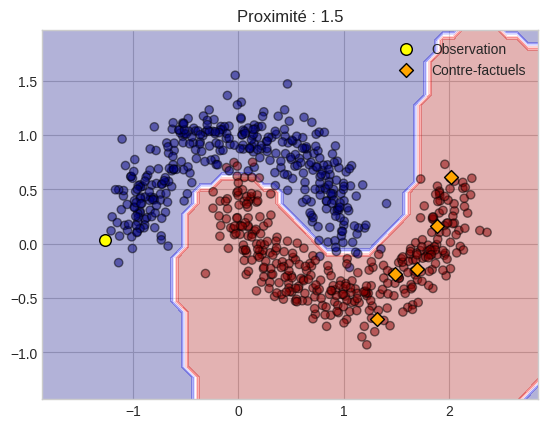

         x1        x2  label
0  1.884327  0.163561      1
1  1.693320 -0.230785      1
2  1.315567 -0.697166      1
3  2.013930  0.610216      1
4  1.483104 -0.277079      1
Proximité des exemples :  [array([[3.15438128, 2.9723466 , 2.68401451, 3.33171748, 2.76781665]])]
Ratio de parcimonie  5.0


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


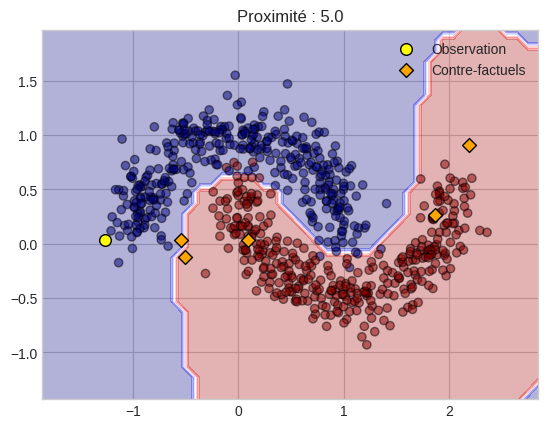

         x1        x2  label
0  0.093216  0.032595      1
1 -0.503555 -0.119898      1
2  2.189637  0.909493      1
3 -0.544603  0.032595      1
4  1.865791  0.263780      1
Proximité des exemples :  [array([[1.36055046, 0.77885407, 3.56645489, 0.72273137, 3.14164377]])]
Ratio de parcimonie  4.0


In [ ]:
df_x = df.drop('label', axis = 1)
y = df['label']
X_train, X_test, Y_train, Y_test = train_test_split(df_x, y, test_size = 0.3, random_state = 42)

clf = SVC(kernel ='rbf', C= 1.0, probability=True).fit(X_train, Y_train)
print("Classe de l'observation",clf.predict(X_test[0:1]))

data = dice_ml.Data(dataframe=df, continuous_features=['x1', 'x2'], outcome_name = 'label')

var_prox(clf, X_test[0:1], data, 'random')

Nous remarquons que les exemples contre-factuels restent valides.

En ce qui concerne la proximité, nous remarquons que pour une proximity_weight élevée (p = 5), les contre-factuels générés sont plus proches de l'observation contrairement aux autres cas.


#### 3. Variation de la diversité
Autrement dit, variation de la variable diversity_weight

In [ ]:
def var_div(clf,obs, data, methode):

  div = [0.25,0.5,1.0,1.5,5.0]

  model = dice_ml.Model(model = clf, backend='sklearn')
  if methode is None :
      explainer = dice_ml.Dice(data,model)
  else :
      explainer = dice_ml.Dice(data, model, methode)

  for d in div :
    proximite = []
    #On génére 5 contre-factuels
    counterfactuals = explainer.generate_counterfactuals(obs,
                                                     total_CFs = 5,
                                                     desired_class = "opposite",
                                                     proximity_weight=0.5,
                                                     diversity_weight=d,
                                                     features_to_vary="all",
                                                     permitted_range=None,
                                                     posthoc_sparsity_param=0.1)
    e_opts = counterfactuals.cf_examples_list[0].final_cfs_df
    title = "Diversité : "+ str(d)
    visualisation(clf,obs.to_numpy(),e_opts.to_numpy(),title )
    print(e_opts)
    proximite.append(distance.cdist(obs.to_numpy(), e_opts.drop('label', axis = 1).to_numpy(), 'euclidean'))
    print("Proximité des exemples : ",proximite)
    print("Ratio de parcimonie ",calculate_sparsity(obs.to_numpy(),e_opts.drop('label', axis = 1).to_numpy()))


Classe de l'observation [0]


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


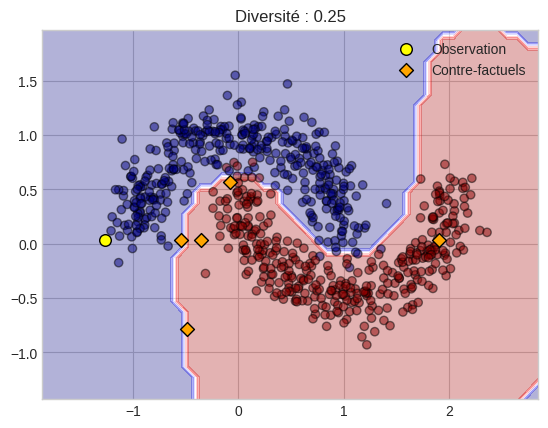

         x1        x2  label
0  1.903112  0.032595      1
1 -0.542526  0.032595      1
2 -0.488814 -0.787816      1
3 -0.357200  0.032595      1
4 -0.074878  0.564988      1
Proximité des exemples :  [array([[3.17044628, 0.72480919, 1.13100337, 0.91013509, 1.3059081 ]])]
Ratio de parcimonie  3.5


100%|██████████| 1/1 [00:17<00:00, 17.63s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


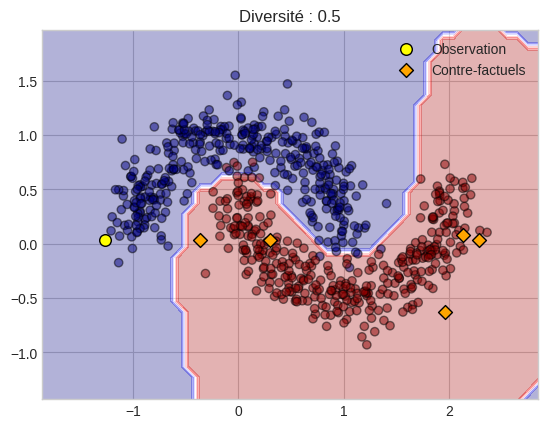

         x1        x2  label
0 -0.358840  0.032595      1
1  2.278441  0.032595      1
2  1.954405 -0.625590      1
3  0.298229  0.032595      1
4  2.132873  0.078325      1
Proximité des exemples :  [array([[0.90849481, 3.54577529, 3.28828389, 1.56556376, 3.40051559]])]
Ratio de parcimonie  3.5


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


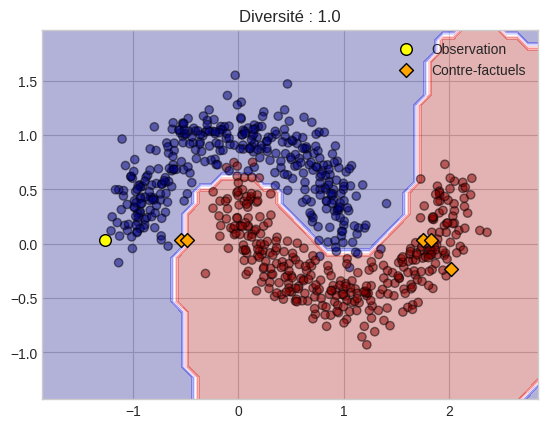

         x1        x2  label
0 -0.539752  0.032595      1
1  1.745977  0.032595      1
2 -0.488574  0.032595      1
3  2.014439 -0.233536      1
4  1.828763  0.032595      1
Proximité des exemples :  [array([[0.72758264, 3.01331122, 0.77876052, 3.29254666, 3.09609728]])]
Ratio de parcimonie  3.0


100%|██████████| 1/1 [00:17<00:00, 17.07s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


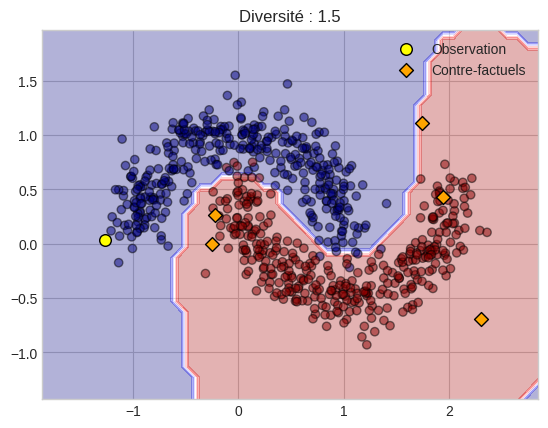

         x1        x2  label
0  1.941387  0.431271      1
1  1.744583  1.114470      1
2 -0.251340  0.001063      1
3  2.298646 -0.691147      1
4 -0.221340  0.264503      1
Proximité des exemples :  [array([[3.23339385, 3.20032873, 1.01648408, 3.63868397, 1.0713947 ]])]
Ratio de parcimonie  5.0


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


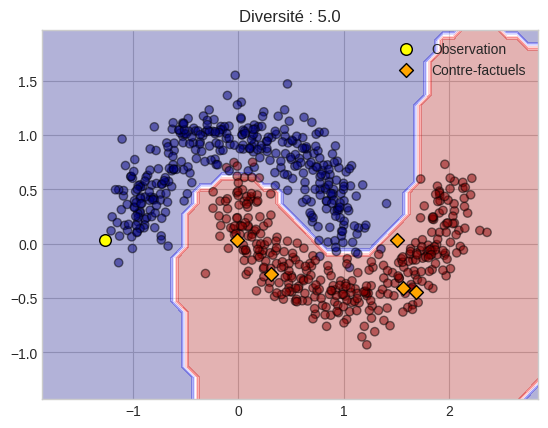

         x1        x2  label
0  1.681043 -0.443000      1
1  0.313869 -0.281342      1
2  1.507896  0.032595      1
3 -0.016974  0.032595      1
4  1.559000 -0.408286      1
Proximité des exemples :  [array([[2.98648971, 1.61206788, 2.77523024, 1.25036035, 2.86051456]])]
Ratio de parcimonie  4.0


In [ ]:
df_x = df.drop('label', axis = 1)
y = df['label']
X_train, X_test, Y_train, Y_test = train_test_split(df_x, y, test_size = 0.3, random_state = 42)

clf = SVC(kernel ='rbf', C= 1.0, probability=True).fit(X_train, Y_train)
print("Classe de l'observation",clf.predict(X_test[0:1]))

data = dice_ml.Data(dataframe=df, continuous_features=['x1', 'x2'], outcome_name = 'label')

var_div(clf, X_test[0:1], data, 'random')

On remarque que pour une diversity_weight élevée, l'algorithme va accorder plus d'importance à la diversité. Ce qui explique la génération d'exemple contre-factuels moins proches de l'origine (exemple pour d = 5) contrairement aux diversités plus faibles qui accordent moins d'importance à la diversité des exemples générés.

#### 4. Variation de la parcimonie

Autrement dit de la variable **posthoc_sparsity_param**

In [ ]:
def var_spars(clf,obs, data, methode):

  spars = [0,0.001,0.1,0.5,1]

  model = dice_ml.Model(model = clf, backend='sklearn')
  if methode is None :
      explainer = dice_ml.Dice(data,model)
  else :
      explainer = dice_ml.Dice(data, model, methode)

  for s in spars :
    proximite = []
    #On génére 5 contre-factuels
    counterfactuals = explainer.generate_counterfactuals(obs,
                                                     total_CFs = 5,
                                                     desired_class = "opposite",
                                                     proximity_weight=0.5,
                                                     diversity_weight=1.0,
                                                     features_to_vary="all",
                                                     permitted_range=None,
                                                     posthoc_sparsity_param=s)
    e_opts = counterfactuals.cf_examples_list[0].final_cfs_df
    title = "Parcimonie : "+ str(s)
    visualisation(clf,obs.to_numpy(),e_opts.to_numpy(),title )
    print(e_opts)
    proximite.append(distance.cdist(obs.to_numpy(), e_opts.drop('label', axis = 1).to_numpy(), 'euclidean'))
    print("Proximité des exemples : ",proximite)
    print("Ratio de parcimonie ",calculate_sparsity(obs.to_numpy(),e_opts.drop('label', axis = 1).to_numpy()))


Classe de l'observation [0]


100%|██████████| 1/1 [00:00<00:00, 10.07it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


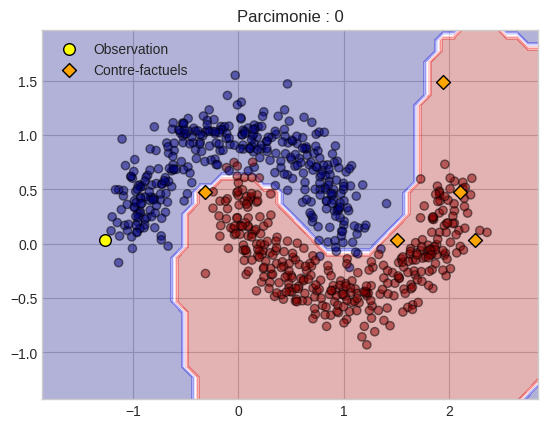

         x1        x2  label
0  2.238648  0.032595      1
1  2.104441  0.471137      1
2  1.940025  1.484787      1
3 -0.320454  0.476589      1
4  1.505342  0.032595      1
Proximité des exemples :  [array([[3.50598273, 3.40017512, 3.52079835, 1.0458074 , 2.77267682]])]
Ratio de parcimonie  4.0


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


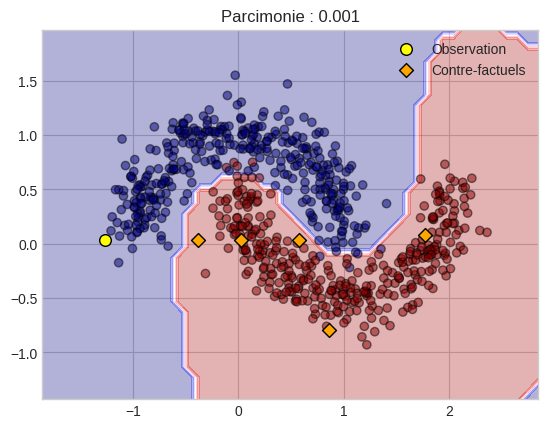

         x1        x2  label
0  0.029359  0.032595      1
1  0.575491  0.032595      1
2 -0.378141  0.032595      1
3  0.858121 -0.794004      1
4  1.772762  0.081123      1
Proximité des exemples :  [array([[1.29669404, 1.84282525, 0.8891938 , 2.28053254, 3.04048435]])]
Ratio de parcimonie  3.5


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


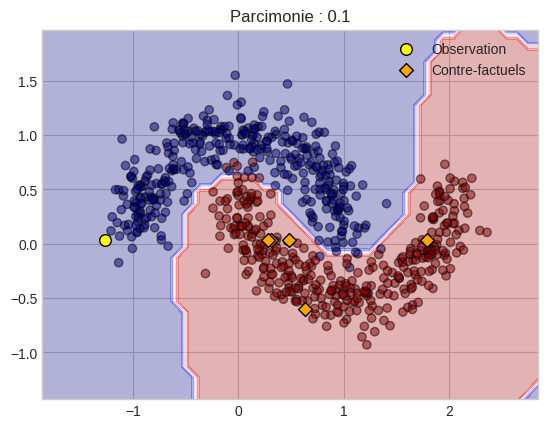

         x1        x2  label
0  0.305396  0.032595      1
1  0.635230 -0.597936      1
2  0.278242  0.032595      1
3  0.481125  0.032595      1
4  1.791396  0.032595      1
Proximité des exemples :  [array([[1.5727303 , 2.00432588, 1.54557714, 1.74845925, 3.0587303 ]])]
Ratio de parcimonie  3.0


100%|██████████| 1/1 [00:17<00:00, 17.24s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


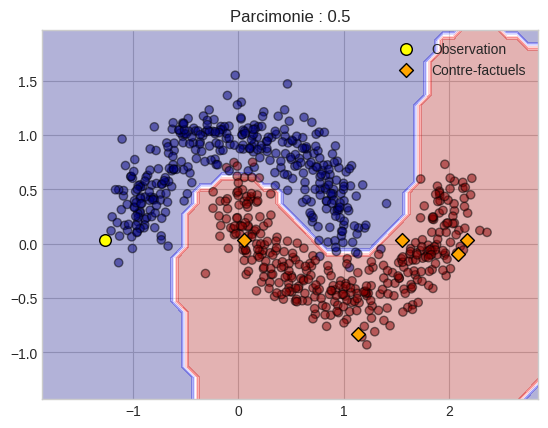

         x1        x2  label
0  1.131367 -0.831511      1
1  2.083916 -0.091063      1
2  0.054982  0.032595      1
3  1.553094  0.032595      1
4  2.164613  0.032595      1
Proximité des exemples :  [array([[2.54959812, 3.35353146, 1.32231665, 2.82042853, 3.43194806]])]
Ratio de parcimonie  3.5


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


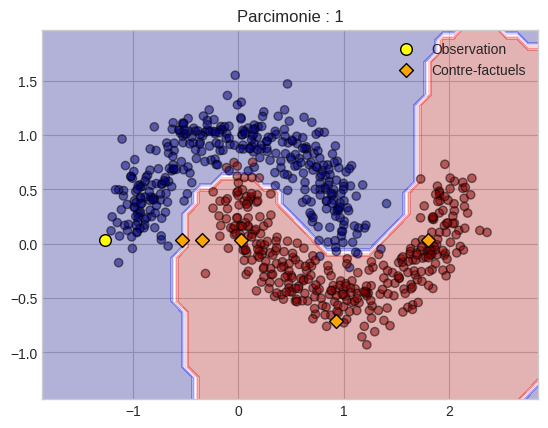

         x1        x2  label
0  0.923816 -0.711704      1
1  0.027570  0.032595      1
2  1.792967  0.032595      1
3 -0.536030  0.032595      1
4 -0.341963  0.032595      1
Proximité des exemples :  [array([[2.31411358, 1.29490459, 3.0603021 , 0.73130422, 0.92537167]])]
Ratio de parcimonie  3.0


In [ ]:
df_x = df.drop('label', axis = 1)
y = df['label']
X_train, X_test, Y_train, Y_test = train_test_split(df_x, y, test_size = 0.3, random_state = 42)

clf = SVC(kernel ='rbf', C= 1.0, probability=True).fit(X_train, Y_train)
print("Classe de l'observation",clf.predict(X_test[0:1]))

data = dice_ml.Data(dataframe=df, continuous_features=['x1', 'x2'], outcome_name = 'label')

var_spars(clf, X_test[0:1], data, 'random')

On remarque que pour une valeur élevée de *posthoc_sparsity_param*, l'algorithme va générer des exemples contre-factuels très similaires à l'observation, puisqu'ils nécessiteront un nombre minim de modifications.

### 6.4 Application sur données réelles

Nous allons nous intéressés aux données **load_breast_cancer** comme dans le TME précédent  

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
bc = load_breast_cancer()
df_bc = pd.DataFrame(bc.data, columns = bc.feature_names)
df_bc

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
0             0.27760         0.30010              0.14710         0.2419   
1             0.07864         0.08690              0.07017         0.1812   
2             0.15990         0.19740              0.12790         0.2069   
3             0.28390         0.24140              0.10520         0.2597   
4             0.13280         0.19800              0.10430         0.1809   
..                ...             ...                  ...            ...   
564           0.11590         0.24390              0.13890         0.1726   
565           0.10340         0.14400              0.09791         0.1752   
566           0.10230         0.09251              0.05302         0.1590   
567           0.27700         0.35140              0.15200         0.2397   
568           0.04362         0.00000              0.00000         0.1587   

     mean fractal dimension  ...  worst radius  worst texture  \
0                   0.07871  ...        25.380          17.33   
1                   0.05667  ...        24.990          23.41   
2                   0.05999  ...        23.570          25.53   
3                   0.09744  ...        14.910          26.50   
4                   0.05883  ...        22.540          16.67   
..                      ...  ...           ...            ...   
564                 0.05623  ...        25.450          26.40   
565                 0.05533  ...        23.690          38.25   
566                 0.05648  ...        18.980          34.12   
567                 0.07016  ...        25.740          39.42   
568                 0.05884  ...         9.456          30.37   

     worst perimeter  worst area  worst smoothness  worst compactness  \
0             184.60      2019.0           0.16220            0.66560   
1             158.80      1956.0           0.12380            0.18660   
2             152.50      1709.0           0.14440            0.42450   
3              98.87       567.7           0.20980            0.86630   
4             152.20      1575.0           0.13740            0.20500   
..               ...         ...               ...                ...   
564           166.10      2027.0           0.14100            0.21130   
565           155.00      1731.0           0.11660            0.19220   
566           126.70      1124.0           0.11390            0.30940   
567           184.60      1821.0           0.16500            0.86810   
568            59.16       268.6           0.08996            0.06444   

     worst concavity  worst concave points  worst symmetry  \
0             0.7119                0.2654          0.4601   
1             0.2416                0.1860          0.2750   
2             0.4504                0.2430          0.3613   
3             0.6869                0.2575          0.6638   
4             0.4000                0.1625          0.2364   
..               ...                   ...             ...   
564           0.4107                0.2216         

In [ ]:
df_bc['Labels'] = bc.target
df_bc

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
0             0.27760         0.30010              0.14710         0.2419   
1             0.07864         0.08690              0.07017         0.1812   
2             0.15990         0.19740              0.12790         0.2069   
3             0.28390         0.24140              0.10520         0.2597   
4             0.13280         0.19800              0.10430         0.1809   
..                ...             ...                  ...            ...   
564           0.11590         0.24390              0.13890         0.1726   
565           0.10340         0.14400              0.09791         0.1752   
566           0.10230         0.09251              0.05302         0.1590   
567           0.27700         0.35140              0.15200         0.2397   
568           0.04362         0.00000              0.00000         0.1587   

     mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                   0.07871  ...          17.33           184.60      2019.0   
1                   0.05667  ...          23.41           158.80      1956.0   
2                   0.05999  ...          25.53           152.50      1709.0   
3                   0.09744  ...          26.50            98.87       567.7   
4                   0.05883  ...          16.67           152.20      1575.0   
..                      ...  ...            ...              ...         ...   
564                 0.05623  ...          26.40           166.10      2027.0   
565                 0.05533  ...          38.25           155.00      1731.0   
566                 0.05648  ...          34.12           126.70      1124.0   
567                 0.07016  ...          39.42           184.60      1821.0   
568                 0.05884  ...          30.37            59.16       268.6   

     worst smoothness  worst compactness  worst concavity  \
0             0.16220            0.66560           0.7119   
1             0.12380            0.18660           0.2416   
2             0.14440            0.42450           0.4504   
3             0.20980            0.86630           0.6869   
4             0.13740            0.20500           0.4000   
..                ...                ...              ...   
564           0.14100            0.21130           0.4107   
565           0.11660            0.19220           0.3215   
566           0.11390            0.30940           0.3403   
567           0.16500            0.86810           0.9387   
568           0.08996            0.06444           0.0000   

     worst concave points  worst symmetry  worst fractal dimension  Labels  
0                  0.2654          0.4601                  0.11890       0  
1                  0.1860          0.2750                  0.08902       0  
2                  0.2430          0.3613                  0.08758       0  
3                  0.2575          0.6638                  0.17300       0  
4                  0.1625          0.2364                  0.076

In [ ]:
type(bc.feature_names)

numpy.ndarray

In [ ]:
df_bc_x = df_bc.drop('Labels', axis = 1)
y = df_bc['Labels']

X_train, X_test, Y_train,Y_test = train_test_split(df_bc_x, y, test_size = 0.3, random_state=0)

data = dice_ml.Data(dataframe=df_bc,continuous_features = list(bc.feature_names),outcome_name='Labels')

clf = SVC(kernel='rbf', C=1.0, probability=True).fit(X_train,Y_train)
model = dice_ml.Model(model= clf, backend='sklearn')

explainer = dice_ml.Dice(data,model, method = 'random')
x = X_test[49:50]
counterfactuals = explainer.generate_counterfactuals(x,
                                                     total_CFs = 3,
                                                     desired_class = "opposite",
                                                     proximity_weight=0.5,
                                                     diversity_weight=1.0,
                                                     features_to_vary="all",
                                                     permitted_range=None,
                                                     posthoc_sparsity_param=0.1)

e_opts = counterfactuals.cf_examples_list[0].final_cfs_df

100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


In [ ]:
e_opts

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        14.54         27.54          161.85      658.8           0.1139   
1        14.54         27.54           96.73      658.8           0.1139   
2        14.54         27.54           96.73      658.8           0.1139   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.1595          0.1639              0.07364         0.2303   
1            0.1595          0.1639              0.07364         0.2303   
2            0.1595          0.1639              0.07364         0.2303   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07077  ...          37.13            124.1       792.6   
1                 0.07077  ...          37.13            124.1       577.1   
2                 0.07077  ...          37.13            124.1       577.1   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1678             0.6577           0.7026                0.1712   
1            0.1678             0.6577           0.7026                0.1712   
2            0.1678             1.0222           0.7026                0.1712   

   worst symmetry  worst fractal dimension  Labels  
0          0.4218                   0.1341       1  
1          0.4218                   0.1341       1  
2          0.4218                   0.1341       1  

[3 rows x 31 columns]

In [ ]:
z = pd.DataFrame(x)
z

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
15        14.54         27.54           96.73      658.8           0.1139   

    mean compactness  mean concavity  mean concave points  mean symmetry  \
15            0.1595          0.1639              0.07364         0.2303   

    mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
15                 0.07077  ...         17.46          37.13            124.1   

    worst area  worst smoothness  worst compactness  worst concavity  \
15       943.2            0.1678             0.6577           0.7026   

    worst concave points  worst symmetry  worst fractal dimension  
15                0.1712          0.4218                   0.1341  

[1 rows x 30 columns]

In [ ]:
print(clf.predict(x))

[0]


Nous pouvons constater que la donnée à expliquer et l'exemple contre-factuel généré n'appartiennent pas à la même classe.

Tentons à présent, d'identifier les différences entre les deux, autrement dit, l'explication

In [ ]:
e_opt1 = e_opts.drop("Labels",axis=1).iloc[0].to_numpy()
print(np.where(e_opt1 != x))

(array([0, 0]), array([ 2, 23]))


In [ ]:
e_opt2 = e_opts.drop("Labels",axis=1).iloc[1].to_numpy()
print(np.where(e_opt2 != x))

(array([0]), array([23]))


In [ ]:
e_opt3 = e_opts.drop("Labels",axis=1).iloc[2].to_numpy()
print(np.where(e_opt3 != x))

(array([0, 0]), array([23, 25]))


In [ ]:
df_bc.columns[0], df_bc.columns[2], df_bc.columns[7], df_bc.columns[23]

('mean radius', 'mean perimeter', 'mean concave points', 'worst area')

Nous pouvons constater que les exemples contre-factuels générés sont relativement proches de la donnée x que nous cherchons à expliquer, tout en appartenant à une classe opposée.

In [ ]:
counterfactuals.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


mean radius  mean texture  mean perimeter   mean area  mean smoothness  \
0        14.54     27.540001       96.730003  658.799988           0.1139   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.1595          0.1639              0.07364         0.2303   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07077  ...      37.130001       124.099998  943.200012   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1678             0.6577           0.7026                0.1712   

   worst symmetry  worst fractal dimension  Labels  
0          0.4218                   0.1341       0  

[1 rows x 31 columns]


Diverse Counterfactual set (new outcome: 1.0)


mean radius mean texture mean perimeter mean area mean smoothness  \
0       14.54        27.54         161.85     658.8          0.1139   
1       14.54        27.54          96.73     658.8          0.1139   
2       14.54        27.54          96.73     658.8          0.1139   

  mean compactness mean concavity mean concave points mean symmetry  \
0           0.1595         0.1639             0.07364        0.2303   
1           0.1595         0.1639             0.07364        0.2303   
2           0.1595         0.1639             0.07364        0.2303   

  mean fractal dimension  ... worst texture worst perimeter worst area  \
0                0.07077  ...         37.13           124.1      792.6   
1                0.07077  ...         37.13           124.1      577.1   
2                0.07077  ...         37.13           124.1      577.1   

  worst smoothness worst compactness worst concavity worst concave points  \
0           0.1678            0.6577          0.7026               0.1712   
1           0.1678            0.6577          0.7026               0.1712   
2           0.1678            1.0222          0.7026               0.1712   

  worst symmetry worst fractal dimension Labels  
0         0.4218                  0.1341    1.0  
1         0.4218                  0.1341    1.0  
2         0.4218                  0.1341    1.0  

[3 rows x 31 columns]

In [ ]:
#changement de la proximité
counterfactuals = explainer.generate_counterfactuals(x,
                                                     total_CFs = 3,
                                                     desired_class = "opposite",
                                                     proximity_weight=1,
                                                     diversity_weight=1.0,
                                                     features_to_vary="all",
                                                     permitted_range=None,
                                                     posthoc_sparsity_param=0.1)
counterfactuals.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

Query instance (original outcome : 0)


mean radius  mean texture  mean perimeter   mean area  mean smoothness  \
0        14.54     27.540001       96.730003  658.799988           0.1139   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.1595          0.1639              0.07364         0.2303   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07077  ...      37.130001       124.099998  943.200012   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1678             0.6577           0.7026                0.1712   

   worst symmetry  worst fractal dimension  Labels  
0          0.4218                   0.1341       0  

[1 rows x 31 columns]


Diverse Counterfactual set (new outcome: 1.0)


mean radius mean texture mean perimeter mean area mean smoothness  \
0       14.54        27.54          96.73     658.8          0.1139   
1       14.54        27.54          96.73     658.8          0.1139   
2       14.54        14.18          96.73     658.8          0.1139   

  mean compactness mean concavity mean concave points mean symmetry  \
0           0.1595         0.1639             0.07364        0.2303   
1           0.1595         0.1639             0.07364        0.2303   
2           0.1595         0.1639             0.07364        0.2303   

  mean fractal dimension  ... worst texture worst perimeter worst area  \
0                0.07077  ...         37.13           124.1      235.0   
1                0.07077  ...         37.13           124.1      230.3   
2                0.07077  ...         37.13           124.1      706.7   

  worst smoothness worst compactness worst concavity worst concave points  \
0           0.1678            0.6577          0.7026               0.1712   
1           0.1678            0.6577          0.7026               0.1712   
2           0.1678            0.6577          0.7026               0.1712   

  worst symmetry worst fractal dimension Labels  
0         0.4218                  0.1341    1.0  
1         0.4218                  0.1341    1.0  
2         0.4218                  0.1341    1.0  

[3 rows x 31 columns]

In [ ]:
e_opts = counterfactuals.cf_examples_list[0].final_cfs_df
e_opt1 = e_opts.drop("Labels",axis=1).iloc[0].to_numpy()
e_opt2 = e_opts.drop("Labels",axis=1).iloc[1].to_numpy()
e_opt3 = e_opts.drop("Labels",axis=1).iloc[2].to_numpy()
print(np.where(e_opt1 != x), np.where(e_opt2 !=e_opt1),np.where(e_opt3 !=e_opt1))

(array([0]), array([23])) (array([23]),) (array([ 1, 23]),)


In [ ]:
e_opts['worst area']

0    235.0
1    230.3
2    706.7
Name: worst area, dtype: float64

On remarque ainsi que qu'en augmantant la proximité dans l'algorithme, les exemples contre-factuels sont beaucoup plus proches de l'observation, ce qui confirme nos expérimentations plus haut

In [ ]:
#changement de la diversité
counterfactuals = explainer.generate_counterfactuals(x,
                                                     total_CFs = 3,
                                                     desired_class = "opposite",
                                                     proximity_weight=0.5,
                                                     diversity_weight=0.25,
                                                     features_to_vary="all",
                                                     permitted_range=None,
                                                     posthoc_sparsity_param=0.1)
counterfactuals.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

Query instance (original outcome : 0)


mean radius  mean texture  mean perimeter   mean area  mean smoothness  \
0        14.54     27.540001       96.730003  658.799988           0.1139   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.1595          0.1639              0.07364         0.2303   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07077  ...      37.130001       124.099998  943.200012   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1678             0.6577           0.7026                0.1712   

   worst symmetry  worst fractal dimension  Labels  
0          0.4218                   0.1341       0  

[1 rows x 31 columns]


Diverse Counterfactual set (new outcome: 1.0)


mean radius mean texture mean perimeter mean area mean smoothness  \
0       14.54        27.54          96.73     658.8          0.1139   
1       14.54        27.54          96.73     658.8          0.1139   
2       14.54        27.54          96.73     658.8          0.1498   

  mean compactness mean concavity mean concave points mean symmetry  \
0           0.1595         0.1639             0.07364        0.2303   
1           0.1595         0.1639             0.07364        0.2303   
2           0.1595         0.1639             0.07364        0.2303   

  mean fractal dimension  ... worst texture worst perimeter worst area  \
0                0.07077  ...         37.13           124.1      698.4   
1                0.07077  ...         37.13           124.1      611.7   
2                0.07077  ...         37.13           124.1      367.7   

  worst smoothness worst compactness worst concavity worst concave points  \
0           0.1678            0.6577          0.7026               0.1712   
1           0.1678            0.6577          0.7026               0.1712   
2           0.1678            0.6577          0.7026               0.1712   

  worst symmetry worst fractal dimension Labels  
0         0.4218                  0.1341    1.0  
1         0.4218                  0.1341    1.0  
2         0.4218                  0.1341    1.0  

[3 rows x 31 columns]

In [ ]:
e_opts = counterfactuals.cf_examples_list[0].final_cfs_df
e_opt1 = e_opts.drop("Labels",axis=1).iloc[0].to_numpy()
e_opt2 = e_opts.drop("Labels",axis=1).iloc[1].to_numpy()
e_opt3 = e_opts.drop("Labels",axis=1).iloc[2].to_numpy()
print(np.where(e_opt1 != x), np.where(e_opt2 != x),np.where(e_opt3 !=x))

(array([0]), array([23])) (array([0, 0]), array([19, 23])) (array([0, 0]), array([ 4, 23]))


Comme prévu, avec un diversity weight moins élevé, l'algorithme nous donne des exemples plus proches de l'observation

In [ ]:
#changement de la diversité
counterfactuals = explainer.generate_counterfactuals(x,
                                                     total_CFs = 3,
                                                     desired_class = "opposite",
                                                     proximity_weight=0.5,
                                                     diversity_weight=1,
                                                     features_to_vary="all",
                                                     permitted_range=None,
                                                     posthoc_sparsity_param=1)
counterfactuals.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

Query instance (original outcome : 0)


mean radius  mean texture  mean perimeter   mean area  mean smoothness  \
0        14.54     27.540001       96.730003  658.799988           0.1139   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.1595          0.1639              0.07364         0.2303   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07077  ...      37.130001       124.099998  943.200012   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1678             0.6577           0.7026                0.1712   

   worst symmetry  worst fractal dimension  Labels  
0          0.4218                   0.1341       0  

[1 rows x 31 columns]


Diverse Counterfactual set (new outcome: 1.0)


mean radius mean texture mean perimeter mean area mean smoothness  \
0       14.54        27.54          96.73     658.8          0.1139   
1       14.54        27.54          96.73     658.8          0.1139   
2       14.54        27.54          96.73     658.8          0.1139   

  mean compactness mean concavity mean concave points mean symmetry  \
0           0.1595         0.1639             0.07364        0.2303   
1           0.1595         0.1639             0.07364        0.2303   
2           0.1595         0.1639             0.07364        0.2303   

  mean fractal dimension  ... worst texture worst perimeter  \
0                0.07077  ...         37.13           124.1   
1                0.07077  ...         37.13           103.1   
2                0.07077  ...         37.13           124.1   

          worst area worst smoothness worst compactness     worst concavity  \
0              654.1           0.1678            0.6577              0.7026   
1  860.2000000000268           0.1678            0.6577              0.7026   
2              307.2           0.1678            0.6577  0.7999999999999999   

  worst concave points worst symmetry worst fractal dimension Labels  
0               0.1712         0.4218                  0.1341    1.0  
1               0.1712         0.4218                  0.1341      -  
2               0.1712         0.4218                  0.1341    1.0  

[3 rows x 31 columns]

In [ ]:
e_opts = counterfactuals.cf_examples_list[0].final_cfs_df
e_opt1 = e_opts.drop("Labels",axis=1).iloc[0].to_numpy()
e_opt2 = e_opts.drop("Labels",axis=1).iloc[1].to_numpy()
e_opt3 = e_opts.drop("Labels",axis=1).iloc[2].to_numpy()
print(np.where(e_opt1 != x), np.where(e_opt2 != x),np.where(e_opt3 !=x))

(array([0, 0]), array([19, 23])) (array([0, 0]), array([22, 23])) (array([0, 0]), array([23, 26]))


Ces différentes expérimentations montrent bien le compromis entre la proximité, parcimonie et diversité dans la génération d'exemples contre-factuels. Tout dépend en effet, de nos objectifs.

## 7. Extension de Growing Spheres

Variante de GS permettant à l’utlisateur de spécifier des attributs non modifiables.
Pour cela, on ajoute une liste contenant les features qui ne peuvent pas subir de changements. Cela revient a limiter l'espace de recherche et ainsi trouver des contrefactuels dans un sous ensemble.

La première partie de l'algorithmme consistant à trouver le point le plus proche de l'exemple que l'on souhaite expliquer reste inchangée. Les modifications s'appliquent a la partie features selection.

In [ ]:
def SL(x,a_0,a_1,n):
  """
  Cette fonction permet de générer des points de la couche sphérique
  selon une distribution uniforme (algorithme donné en TME), tel que :
  x -  le centre de la sphère
  a_0 : int - le rayon interne
  a_1 : int - le rayon externe
  """
  #Ajustement et récupération des dimensions
  x = x.reshape(1,-1)
  d = x.shape[1]
  #Génération de la matrice Z (n,d) : n points dans la sphère de centre 0 et de rayon 1
  z = np.random.normal(0,1,size = (n,d))
  #Calcul de la norme de chaque vecteur z_i de la matrice z
  #L'objectif est que les points générés soient sur la sphère
  normes = np.linalg.norm(z, axis = 1, keepdims = True)
  #Normalisation de la matrice qui contient désormais les éléments normalisés
  z /= normes
  #Génération de n rayon de dimension (1,d) uniformément distribués
  u = (np.random.uniform((a_0**d),(a_1**d), size = (n,d)))**(1/d)

  return x + z * u

In [ ]:
def GSGeneration(model, x, eta:float, n: int):
  """
  Fonction permettant de trouver le point le plus proche n'appartenant pas
  à la même classe que le point x : observation à interpréter et expliquer
  Paramètres:
   classifieur : un classifieur binaire
   x : donnée a expliquer
   eta : le rayon
   n : nombre de points à générer

  Returns:
    e : ennemi (point le plus proche appartenant à la classe inverse par rapport à x)

  """
  #Pour des soucis de dimension uniquement :
  if x.ndim != 2:
    x = x.reshape(1, -1)
  # Generation of z's in SL
  z = SL(x=x, a_0=0.0, a_1=eta, n=n)

  #Recherche du meilleur eta
  while np.any(model.predict(z) != model.predict(x.reshape(1,-1))):
    eta /= 2
    z = SL(x=x, a_0=0.0, a_1=eta, n=n)
  print("Meilleur eta trouvé : ",eta)

  a_0 = eta
  a_1 = 2 * eta

  #Recherche de l'ennemi e
  z = SL(x=x, a_0=a_0, a_1=a_1, n=n)
  # if we reach a good value for eta, we retrieve the closest point
  while not np.any(model.predict(z) != model.predict(x.reshape(1,-1))):
    z = SL(x=x, a_0=a_0, a_1=a_1, n=n)
    a_0 = a_1
    a_1 += eta

   #Return le L2 plus proche ennemi de x
  #On récupère les indices des points n'appartenant pas à la même classe que x
  indices = np.where(model.predict(z) != model.predict(x.reshape(1, -1)))[0]
  z = z[indices]
  e_idx = np.linalg.norm(x - z, axis=1, ord=2).argmin() # sortir tous ceux de la classe differente et prendre le plus proche de x

  return z[e_idx]

In [ ]:
def GSFeatureSelection(classifieur, x, e, unchanging_features):
  """
  Fonction permettant de trouver l'exemple contre-factuel

  Paramètres:
    classifieur : classifieur binaire
    x : observation à interpréter
    e : plus proche ennemi (solution de l'algorithme GSGeneration)
    inchanging_features : liste d'attributs non modifiables

  Returns:
    e_star : l'exemple contre-factuel
  """
  e_prim = e.copy()
  i = 0
  j_s = [] + unchanging_features # liste qui contiendra les dimensions déjà selectionnées auxquelles ont ajoute les dimensions qu'on ne souhaite pas modifier
  while classifieur.predict(e_prim.reshape(1, -1)) != classifieur.predict(x.reshape(1,-1)):
    e_star = e_prim.copy()
    diff = np.abs(e_prim - x)
    diff[0,j_s] = np.inf # attribut une valeur très grand aux dimensions déjà modifiées
    j = diff.argmin()
    if(e_prim[j] != x.flatten()[j]):
      e_prim[j] = x.flatten()[j]
    j_s.append(j) # ajout de la dimension modifié à la liste

  return e_star

In [ ]:
#Test de la fonction sur les données artificielles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

n = 1000
noise = 0.2
x, y = make_moons(n_samples=n, noise = noise)
np.random.seed(42)

X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = 0.3, random_state=42)
clf = SVC(kernel='rbf', C=1.0).fit(X_train, Y_train)
x_ = x[100]
closest_e = GSGeneration(clf,x_.reshape(1,-1),2,1000)
e_opt = GSFeatureSelection(clf,x_.reshape(1,-1),closest_e, [0])

print(e_opt)
print(f"Le plus proche ennemi est : {closest_e}")

Meilleur eta trouvé :  0.5
[-0.53668171 -0.1939682 ]
Le plus proche ennemi est : [-0.53668171 -0.1939682 ]


In [ ]:
def visualisation(classifieur,x_, e_, e_opt,title):
  """
  Fonction permettant de visualiser les éléments mentionnés dans l'énoncé

  Paramètres :
   - Classifieur : le classifieur considéré
   - x : les données du modèle
   - y : les étiquettes
   - x_obs : la donnée à expliquer
   - e_ : l'ennemi de l'algorithme GSGeneration
   - e_opt : l'exemple contre-factuel
   """
  x_min, x_max = x[:,0].min() - .5, x[:,0].max() + .5
  y_min, y_max = x[:,1].min() - .5, x[:,1].max() + .5

  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

  Z = classifieur.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, alpha=.3,cmap="seismic")

  plt.title(title)

  plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', edgecolors='k', alpha=0.5, color=[['navy', 'darkred'][i] for i in Y_train])
  plt.scatter(x_[0], x_[1], marker='o', color='yellow', edgecolors='k', s=150,label="Observation")
  plt.scatter(e_[0], e_[1], marker='D', color='orange', edgecolors='k', s=100,label="e'")
  plt.scatter(e_opt[0], e_opt[1], marker='D', c='green', edgecolors='k', s=100,label="Exemple contre-factuel")

  plt.legend()
  plt.show()

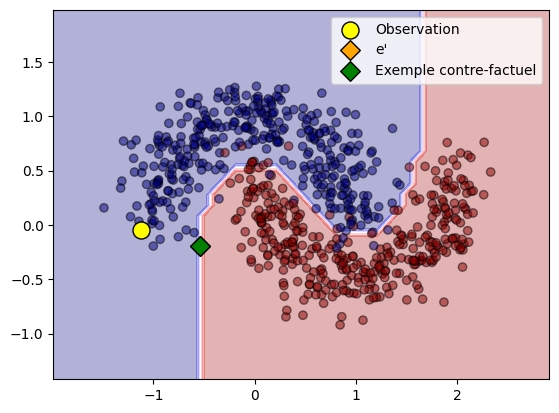

In [ ]:
# visualisation
visualisation(clf,x_, closest_e, e_opt,"")